<div align="right">
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
</div>

<center> 
    <h1>Introducción a la Visión Computacional</h1>
    <h1>Tarea 1</h1>
</center>

### Magíster en Data Science
#### Cristhian Solís Muñoz

-----------------------
<div align="right">
Fecha de Entrega: Martes 22, Abril 2025.
</div>

<div align="center">
<h3>Proyecto Clasificación de patologías en peces de agua dulce a través de Visión Computacional 🐟</h3>
</div>

<p align="center">
  <img src="https://blog.petco.cl/wp-content/uploads/2023/10/22Acua-00.png" alt="Banner Acuicultura" width="100%" height="300">
</p>


## **Resumen**

Se desarrolla los primeros pasos para la generación de un proyecto ligado con visión computacional, partiendo desde la selección de una base de datos de imágenes abierta, aplicando preprocesamiento básico de las imágenes del dataset y finalizando con la definición del plan de trabajo para las siguientes etapas.


### **Librerias**    
Se exponen las librerias utilizadas durante el informe

In [2]:
# Importación de librerias
import os
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    InputLayer, 
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_curve
)

# Visualization
import seaborn as sns

## **Aplicación Propuesta**

En esta etapa inicial, se propone el desarrollo de un clasificador de imágenes que permita identificar si un pez está sano o si presenta signos visibles de enfermedad. No obstante, se contemplan otras posibles líneas de investigación y desarrollo que podrán ser abordadas en entregas posteriores.

Esta propuesta inicial se alinea con el objetivo de explorar el potencial de la visión computacional como herramienta de apoyo en la detección temprana de enfermedades, contribuyendo así a la mejora del bienestar animal y la eficiencia productiva en la industria acuícola.

- **Objetivo**: Clasificar la condición sanitaria de un pez.
- **Justificación**: Esta tarea es relevante en el contexto de la acuicultura, donde la detección temprana de enfermedades puede prevenir pérdidas económicas significativas y vela por el bienestar animal.

## **Descripción y Exploración del Dataset**

En los proximos bloques, se describe y explora el dataset obtenido medieante  [Kaggle](https://www.kaggle.com/datasets/subirbiswas19/freshwater-fish-disease-aquaculture-in-south-asia/data). Denominado **Freshwater Fish Disease Aquaculture in south asia**. 



### **Descripción del dataset**    

El conjunto de datos está compuesto por imágenes recolectadas desde diversas fuentes, incluyendo el departamento de investigación de una universidad, centros acuícolas y portales en línea. La recopilación fue realizada con el apoyo de expertos en sanidad de peces, lo que respalda la validez y precisión de las etiquetas asignadas.

Las imágenes corresponden a diferentes patologías observadas en peces cultivados en sistemas de acuicultura, específicamente durante su etapa en agua dulce.

### **Carga del dataset**    
Se carga la carpeta base, se crea un directorio para almacenar las imagenes resultantes del pre procesamiento del dataset. Se identifican las clases y genera un dataframe con metadatos.

In [3]:
# Ruta donde están las imágenes
base_path = r'C:\Users\csolis\OneDrive - Nutreco Nederland B.V\Desktop\Freshwater-Fish-Disease-Aquaculture\Freshwater-Fish-Disease-Aquaculture\Data\Train'
processed_base_path = r'C:\Users\csolis\OneDrive - Nutreco Nederland B.V\Desktop\Freshwater-Fish-Disease-Aquaculture\Freshwater-Fish-Disease-Aquaculture\Data\Train_Processed'

# Crear directorio para imágenes procesadas si no existe
if not os.path.exists(processed_base_path):
    os.makedirs(processed_base_path)

# Listar clases (subcarpetas)
clases = os.listdir(base_path)
clases_processed = os.listdir(processed_base_path)

In [4]:
# Generación DF metadatos
# Lista para almacenar metadata
metadata = []

# Recorrer las carpetas/clases
for clase in clases:
    clase_path = os.path.join(base_path, clase)
    for nombre_img in os.listdir(clase_path):
        ruta_img = os.path.join(clase_path, nombre_img)
        try:
            with Image.open(ruta_img) as img:
                formato = img.format
                ancho, alto = img.size
                modo_color = img.mode  # RGB, L, etc.
                shape = img.size + (3,) if modo_color == 'RGB' else img.size + (1,)  # Agregar canal de color
                metadata.append({
                    'clase': clase,
                    'archivo': nombre_img,
                    'formato': formato,
                    'ancho': ancho,
                    'alto': alto,
                    'modo_color': modo_color,
                    'shape': shape
                })
        except Exception as e:
            print(f"Error al leer {ruta_img}: {e}")

# Crear DataFrame con la metadata
df_metadata = pd.DataFrame(metadata)

### **Exploración del Dataset**

Se realiza una exploración inicial del dataset con el objetivo de comprender su estructura y características principales. Para ello, se abordan las siguientes preguntas clave:

- ¿Cuál es el tamaño del dataset?  
- ¿Cuáles son las clases disponibles y cuántas hay? 
- ¿Cuántas imágenes hay por clase?  
- ¿Qué tipos de archivos contiene el dataset?
- ¿Cuáles son los tamaños de los archivos existentes en el dataset?
- ¿Cuáles son las dimensiones (shape) de las imágenes?
- ¿Qué tipos de modo de color existen?


In [5]:
# ¿Cuál es el tamaño del dataset?
total_imagenes = len(df_metadata)
print(f"El Dataset contiene {total_imagenes} imagenes")

El Dataset contiene 1750 imagenes


In [6]:
# ¿Cuáles son las clases disponibles y cuántas hay? 
clases_unicas = sorted(df_metadata['clase'].unique())
num_clases = len(clases_unicas)

print(f"Existen {num_clases} clases")
print("Las cuáles son:")
for i, clase in enumerate(clases_unicas, start=1):
    print(f"  {i}. {clase}")

Existen 7 clases
Las cuáles son:
  1. Bacterial Red disease
  2. Bacterial diseases - Aeromoniasis
  3. Bacterial gill disease
  4. Fungal diseases Saprolegniasis
  5. Healthy Fish
  6. Parasitic diseases
  7. Viral diseases White tail disease


Se describen las clases identificadas y una breve descripción de la clase

| Clase                                    | Descripción                                    |
|------------------------------------------|------------------------------------------------|
| Bacterial Red disease                    | Enfermedad bacteriana con manchas rojas        |
| Bacterial diseases - Aeromoniasis        | Infección bacteriana causada por Aeromonas     |
| Bacterial gill disease                   | Enfermedad bacteriana que afecta las branquias |
| Fungal diseases Saprolegniasis           | Infección fúngica que afecta la piel del pez  |
| Healthy Fish                             | Peces sanos sin signos de enfermedad           |
| Parasitic diseases                       | Enfermedades causadas por parásitos            |
| Viral diseases White tail disease        | Enfermedad viral que afecta la cola del pez    |



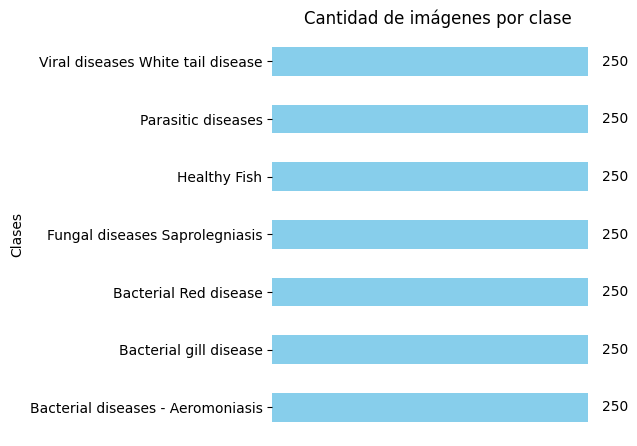

In [7]:
# ¿Cuántas imágenes hay por clase?  
conteo_por_clase = df_metadata['clase'].value_counts().reset_index(name='cantidad').rename(columns={'index': 'clase'})
# Crear gráfico de barras
ax = conteo_por_clase.plot(kind='barh', 
                           x='clase', 
                           y='cantidad',
                           ylabel='Clases',
                           color='skyblue',
                           legend=False,
                           title='Cantidad de imágenes por clase')

# Agregar los totales sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                xytext=(10, 0), textcoords='offset points', 
                ha='left', va='center', fontsize=10, color='black')
    
# Ajustar el gráfico para mejor presentación
plt.tight_layout()
ax.xaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

Se observa una distribución uniforme, con 250 archivos por clase en el dataset, lo que representa un escenario ideal para el modelado de datos dado que las clases se encuentran balanceadas

In [8]:
# ¿Qué tipos de archivos contiene el dataset?
print("\nTipos de formato de imagen:")
print(df_metadata['formato'].value_counts())
print("\n-----")


Tipos de formato de imagen:
formato
JPEG    1718
PNG       29
WEBP       3
Name: count, dtype: int64

-----


El dataset incluye imágenes en tres formatos distintos. Para los fines de este proyecto, se sugiere el uso exclusivo de imágenes fotográficas de carácter productivo. 

En ese sentido, se recomienda trabajar únicamente con archivos en formato **JPEG**, ya que representan de mejor forma condiciones reales de captura y ofrecen mayor consistencia para procesos de entrenamiento en modelos de visión computacional.

In [9]:
# ¿Cuáles son los tamaños de los archivos existentes en el dataset?
print("\nTamaños más frecuentes:")
print(df_metadata.groupby(['ancho', 'alto']).size().sort_values(ascending=False).head(5))


Tamaños más frecuentes:
ancho  alto
128    128     1291
224    224      449
184    136        1
116    212        1
224    62         1
dtype: int64


In [10]:
# ¿Cuáles son las dimensiones (shape) de las imágenes?
print("\nDimensiones (shape) de las imágenes:")
print(df_metadata['shape'].value_counts())


Dimensiones (shape) de las imágenes:
shape
(128, 128, 3)    1291
(224, 224, 3)     449
(224, 80, 3)        1
(224, 109, 3)       1
(224, 62, 3)        1
(184, 136, 3)       1
(224, 110, 3)       1
(116, 212, 3)       1
(224, 71, 3)        1
(224, 69, 3)        1
(224, 73, 3)        1
(224, 97, 3)        1
Name: count, dtype: int64


In [11]:
# ¿Qué tipos de modo de color existen?
print("\nModos de color de las imágenes:")
print(df_metadata['modo_color'].value_counts())
print("\n-----")


Modos de color de las imágenes:
modo_color
RGB    1750
Name: count, dtype: int64

-----


Resumiendo las características de las imágenes presentes en el dataset, el conjunto de datos está compuesto por imágenes en modo de color RGB, con tres canales, lo que resulta adecuado para representar información visual en tareas de VC.

En cuanto a las dimensiones, predominan dos tamaños principales: 128x128 y 224x224 píxeles. Sin embargo, también se identifican algunas imágenes con resoluciones atípicas. Esta variabilidad refuerza la importancia de estandarizar las dimensiones durante el preprocesamiento, con el fin de preparar el set de datos para modelos de aprendizaje profundo.

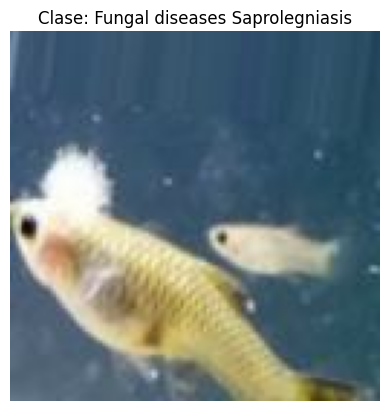

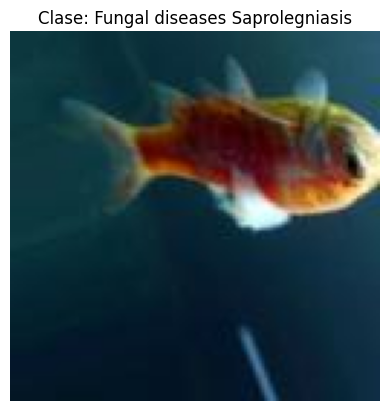

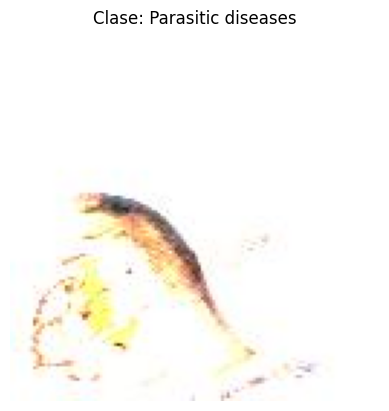

In [12]:
# Visualización de las imagenes del dataset
for img_name in random.sample(df_metadata['archivo'].tolist(), 3):
    img_path = os.path.join(base_path, df_metadata.loc[df_metadata['archivo'] == img_name, 'clase'].values[0], img_name)
    
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Clase: {df_metadata.loc[df_metadata['archivo'] == img_name, 'clase'].values[0]}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Imagen no encontrada: {img_path}")

Se finaliza esta etapa con la visualización de tres imágenes aleatorias del dataset, con el objetivo de observar ejemplos del conjunto de datos en su estado original antes del preprocesamiento.

## **Preprocesamiento**

Se generan distintas acciones para preprocesar el set de imagenes, con foco en la aplicacion propuesta previamente. 

Se realizan acciones, cómo, reescalar las dimensiones buscando la estandarización para habilitar su empaquetamiento en batch uniformes. Seleccionar estrateficada un único formato **JPEG**, con el objetivo de eliminar imagenes de origen digital. Finalmente, se almacenan las imagenes resultantes en un nuevo directorio para la manteción del dataset original y  se expone un set de ejemplo.


### **Redimensionamiento**    

En esta etapa, las imágenes se redimensionan a un tamaño estándar (512x512 píxeles), lo que permite asegurar que todas las imágenes sean compatibles para su procesamiento en batch y se procesan solo imagenes en formato JPEG.

Este proceso es crucial para preparar el dataset para  entrenamiento de modelos, garantizando que las imágenes tengan un tamaño uniforme.

In [13]:
# Función para redimensionar la imagen
def redimenzionar_y_formato(image_path):
    img = Image.open(image_path)
    img_resized = img.convert('RGB').resize((224, 224)) 
    return np.array(img_resized)

# Recorrer cada clase y procesar las imágenes
for clase in clases:
    clase_path = os.path.join(base_path, clase)
    processed_clase_path = os.path.join(processed_base_path, clase)

    # Crear directorio para cada clase procesada si no existe
    if not os.path.exists(processed_clase_path):
        os.makedirs(processed_clase_path)

    # Procesar imágenes dentro de cada clase
    for nombre_img in os.listdir(clase_path):
        ruta_img = os.path.join(clase_path, nombre_img)
        
        # Solo procesar imágenes JPEG para considerar origen "productivo real" y no permitir formatos digital
        if ruta_img.lower().endswith('.jpeg') or ruta_img.lower().endswith('.jpg'):
            try:
                # Redimensionar y convertir la imagen
                img_resized = redimenzionar_y_formato(ruta_img)
                
                # Guardar imagen procesada
                processed_img_path = os.path.join(processed_clase_path, nombre_img)
                Image.fromarray(img_resized).save(processed_img_path)
                
            except Exception as e:
                print(f"Error al procesar {ruta_img}: {e}")

### **Aplicación de Filtro Gaussiano**

Una vez redimensionadas las imágenes, se aplica un filtro Gaussiano con el objetivo de suavizar el ruido y mejorar la calidad visual de las imágenes. Este tipo de preprocesamiento ayuda a reducir pequeñas variaciones no representativas en los datos. 

El filtro se aplica a todas las imágenes del conjunto, sobrescribiendo cada archivo con su versión suavizada.

In [14]:
# Función para aplicar filtro gaussiano
def filtro_gaussiano(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Recorrer las imágenes redimensionadas y aplicar el filtro gaussiano
for clase in clases:
    clase_path = os.path.join(processed_base_path, clase)
    
    for nombre_img in os.listdir(clase_path):
        ruta_img = os.path.join(clase_path, nombre_img)
        try:
            # Cargar la imagen procesada
            img = cv2.imread(ruta_img)
            
            # Aplicar el filtro gaussiano
            img_filtered = filtro_gaussiano(img)
            
            # Guardar la imagen procesada con el filtro
            cv2.imwrite(ruta_img, img_filtered)
        
        except Exception as e:
            print(f"Error al aplicar filtro gaussiano a {ruta_img}: {e}")

### **Validaciones**
Se realizan diversas validaciones para asegurar la calidad del preprocesamiento aplicado al dataset, incluyendo:

- Verificación de la presencia de todas las clases definidas.
- Confirmación de que todas las imágenes comparten el mismo formato (JPEG).
- Comprobación de la estandarización en las dimensiones de las imágenes.
- Detección  de archivos corruptos o no legibles.
- Cálculo del tamaño total del dataset tras el preprocesamiento.

Finalmente, se presenta una comparación visual entre el conjunto original y el conjunto procesado, destacando los principales cambios.


In [15]:
# Verificar si todas las clases de Train están presentes en Train_Processed
clases_train = os.listdir(base_path)
clases_processed = os.listdir(processed_base_path)

# Comprobar si todas las clases de Train están en Train_Processed
missing_classes = set(clases_train) - set(clases_processed)
if missing_classes:
    print(f"Faltan las siguientes clases en Train_Processed: {missing_classes}")
else:
    print("Todas las clases están presentes en Train_Processed.")


Todas las clases están presentes en Train_Processed.


In [16]:
# Verificar el formato de las imágenes procesadas
for clase in clases_processed:
    clase_path = os.path.join(processed_base_path, clase)
    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)
        with Image.open(img_path) as img:
            if img.format != 'JPEG':
                print(f"Imagen no JPEG encontrada: {img_path}")


In [17]:
# Verificar dimensiones de las imágenes procesadas
for clase in clases_processed:
    clase_path = os.path.join(processed_base_path, clase)
    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)
        with Image.open(img_path) as img:
            if img.size != (224, 224):
                print(f"Dimensiones incorrectas en la imagen: {img_path}")


In [18]:
# Verificar imágenes corruptas
for clase in clases_processed:
    clase_path = os.path.join(processed_base_path, clase)
    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verifica que la imagen no esté corrupta
        except (IOError, SyntaxError) as e:
            print(f"Imagen corrupta encontrada: {img_path}")


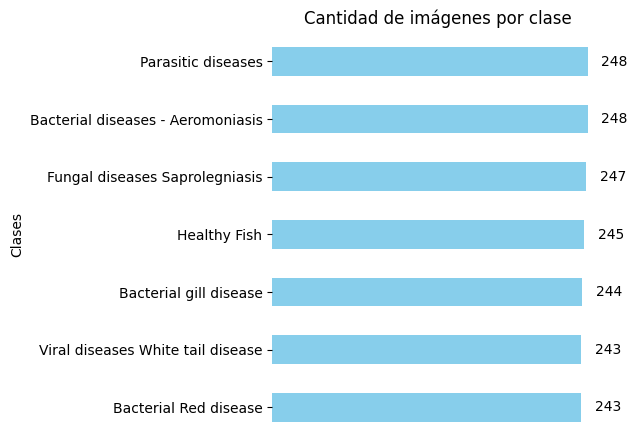

In [19]:
# Contar imágenes por clase
conteo_por_clase = {}
for clase in clases_processed:
    clase_path = os.path.join(processed_base_path, clase)
    conteo_por_clase[clase] = len(os.listdir(clase_path))

# Convertir el conteo a un DataFrame
df_conteo = pd.DataFrame(list(conteo_por_clase.items()), columns=['clase', 'cantidad'])
df_conteo = df_conteo.sort_values(by='cantidad', ascending=True)

# Gráfico horizontal con totales
ax = df_conteo.plot(kind='barh', 
                    x='clase', 
                    y='cantidad',
                    ylabel='Clases',
                    legend=False,
                    title='Cantidad de imágenes por clase',
                    color='skyblue')

# Agregar los totales sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                xytext=(10, 0), textcoords='offset points', 
                ha='left', va='center', fontsize=10, color='black')

# Ajustar presentación
plt.tight_layout()
ax.xaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

Al procesar exclusivamente imágenes en formato JPEG, se observa una reducción en la cantidad total de archivos por clase. Este ajuste afecta por igual a todas las categorías, manteniendo así la proporcionalidad original del dataset y asegurando un equilibrio adecuado entre clases para entrenamiento de modelos.

In [20]:
# Contar el total de imágenes en todas las clases
total_imagenes = 0
for clase in clases_processed:
    clase_path = os.path.join(processed_base_path, clase)
    total_imagenes += len(os.listdir(clase_path))

# Mostrar el total de archivos
print(f"Total de imágenes procesadas: {total_imagenes}")

Total de imágenes procesadas: 1718


Como se observó durante la exploración del dataset, este contiene un total de 1.718 imágenes en formato JPEG, las cuales se encuentran íntegramente en el directorio Train_Processed. Esto valida que los pasos de procesamiento fueron aplicados correctamente a la totalidad de los archivos definidos como objetivo de trabajo.

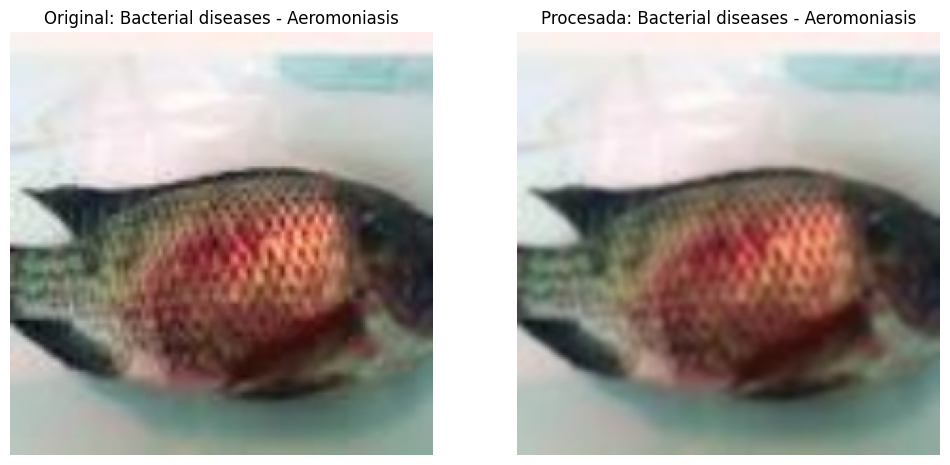

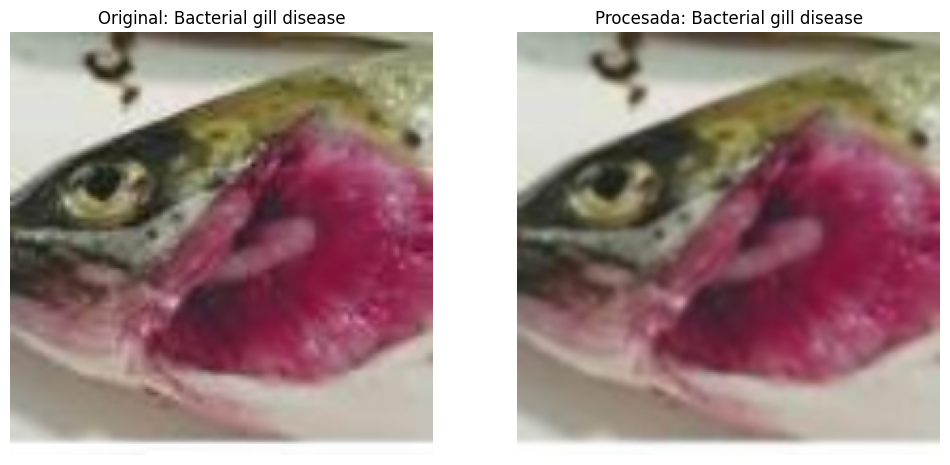

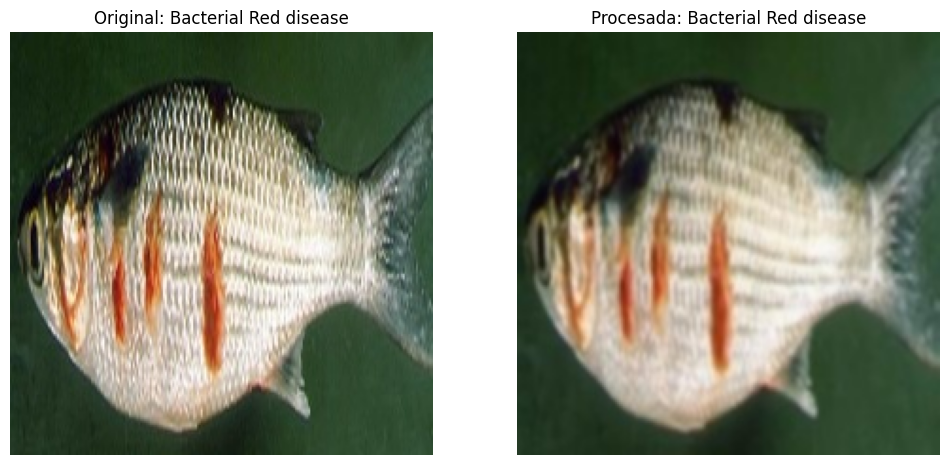

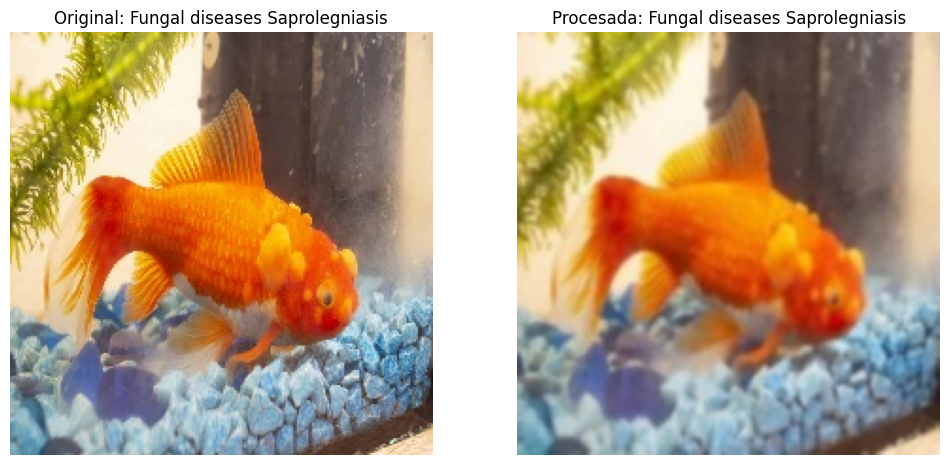

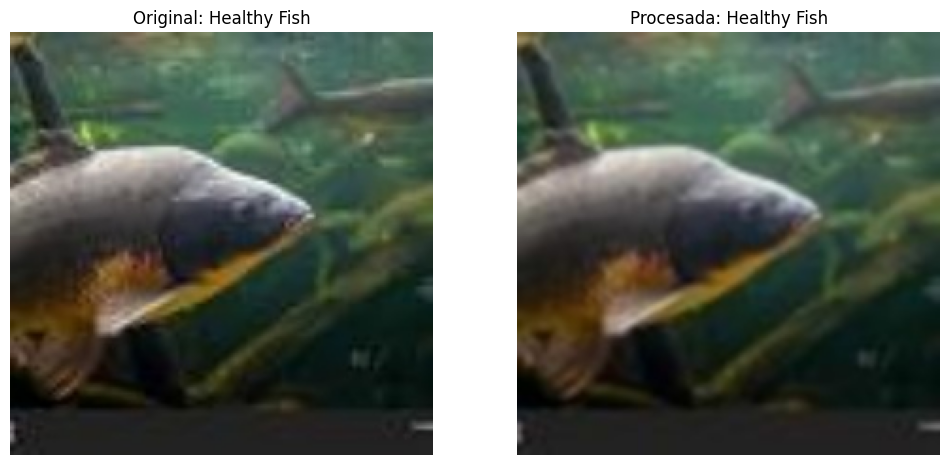

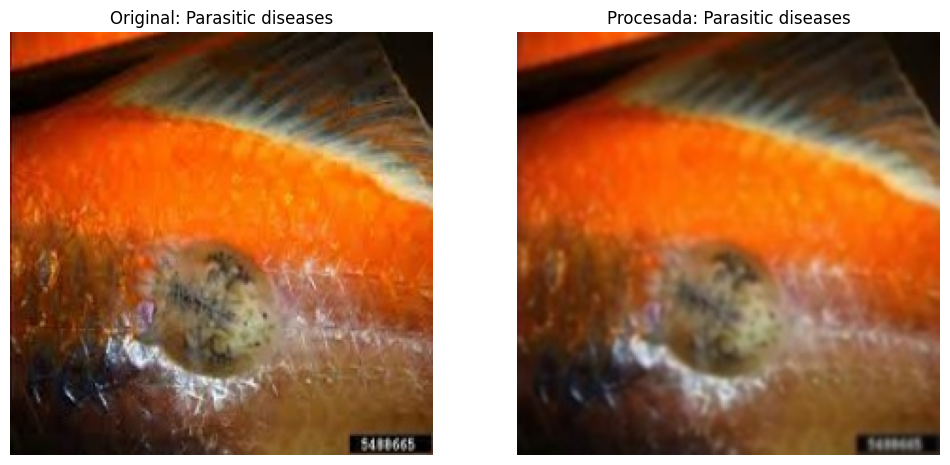

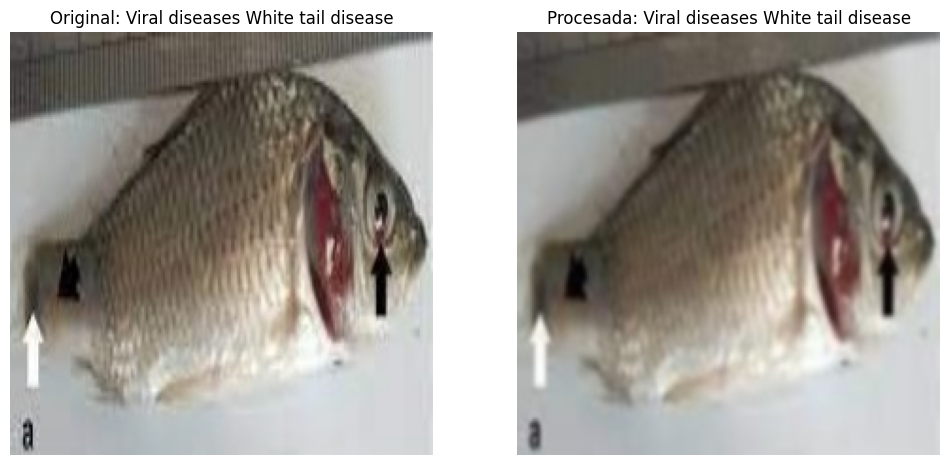

In [21]:
# Comparacion de imagenes procesadas
for clase in clases:
    # Elegir una imagen de la clase
    img_name = os.listdir(os.path.join(base_path, clase))[0]  # Tomamos la primera imagen de la clase

    # Rutas de la imagen original y procesada
    original_img_path = os.path.join(base_path, clase, img_name)
    processed_img_path = os.path.join(processed_base_path, clase, img_name)

    # Cargar imágenes original y procesada
    original_img = Image.open(original_img_path)
    processed_img = Image.open(processed_img_path)

    # Mostrar comparativa de imágenes
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original: {clase}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(f"Procesada: {clase}")
    plt.axis('off')
    plt.show()

Finalmente, se expone el antes y después de la primera imagen de cada clase, permitiendo visualizar de forma clara los efectos del preprocesamiento aplicado.

## **Clasificador**

En esta etapa inicial, se genera el desarrollo de un clasificador de imágenes que permite identificar el estado de salud de un pez a partir de signos visibles. A diferencia de un modelo binario (sano vs. enfermo), este proyecto propone un enfoque **multiclase**, considerando **7 categorías** que representan diversas condiciones o enfermedades detectables visualmente.


### Carga de set para entrenamiento, validacion y test

Utilizando la directorio donde se almacenaron las imagenes con el preprocesamiento (redimiención y filtro gauss), se preparan los set de datos requerido para desarrollar la arquitectura de una red neuronal.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Recall


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta base
data_path_train_processed = r'C:\Users\csolis\OneDrive - Nutreco Nederland B.V\Desktop\Freshwater-Fish-Disease-Aquaculture\Freshwater-Fish-Disease-Aquaculture\Data\Train_Processed'
data_path_test = r'C:\Users\csolis\OneDrive - Nutreco Nederland B.V\Desktop\Freshwater-Fish-Disease-Aquaculture\Freshwater-Fish-Disease-Aquaculture\Data\Test'

# Definición de parámetros
batch_size = 32
epochs = 50
input_shape = (224, 224, 3)
num_classes = 7

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1) # Normalización de los datos de entrada para que la red converja más rápido y aprenda mejor.
train_gen = datagen.flow_from_directory(
    data_path_train_processed,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical', #one-hot encoding
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path_train_processed,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generador para evaluación final (sin split)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    data_path_test,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1550 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
Found 697 images belonging to 7 classes.


### MODELOS DE APRENDIZAJE PROFUNDO

#### **Arquitectura CNN**



In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def cnn_perzonalizado(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape), #Capa de Entrada con activación ReLU y normalización de pesos
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2), #Capa de MaxPooling para reducir dimensionalidad a ventana 2x2

        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'), #Capa de convolución con activación ReLU y normalización de pesos
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'), # Capa de convolución con activación ReLU y normalización de pesos
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(), # Aplanar la salida de las capas convolucionales
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax') # Capa de salida con activación softmax para clasificación multiclase
    ])
    return model

##### Explicación de la red CNN

> **(1) Conv2D (32 filtros, 3x3, ReLU, padding='same')**  
> * Primera capa,con 32 neuronas donde aprenderá bordes, texturas y patrones básicos.  
> * **BN + Pool** para reducir las dimensiones y activación **ReLU**  
>     ↓  
>  
> **(2) Conv2D (64 filtros, 3x3, ReLU, padding='same')**  
> * Segunda Capa, con 64 neuronas, donde aprende patrones más complejos.  
> * **BN + Pool** continúan el proceso de reducción dimensional.  
>  
>     ↓  
>  
> **(3) Conv2D (128 filtros, 3x3, ReLU, padding='same')**  
> * Tercera Capa, con 128 neuronas, la red aprende características aún más abstractas, se aplica **Dropout (0.3)** para evitar el sobreajuste.  
> * **BN + Pool** para continuar reduciendo las dimensiones.  
>  
>     ↓  
>  
> **(4) Flatten**  
> * Aplana la salida de las capas convolucionales para conectarlo con las capas densas.  
>  
>     ↓  
>  
> **(5) Dense(256, ReLU)**  
> * Aprende combinaciones más complejas de características y se aplica **Dropout (0.5)** para reducir el sobreajuste.  
>  
>     ↓  
>  
> **(6) Dense(num_classes, softmax)**  
> * **Softmax** convierte las activaciones en probabilidades para cada clase.  

La arquitectura va desde extracción de bordes (capas convolucionales) hasta clasificación multiclase (softmax), con regularización mediante Dropout y reducción dimensional por pooling.

#### **La Arquitectura resnet50**

In [36]:
def resnet50(input_shape, num_classes):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Congelar las capas base para evitar que se entrenen
    base.trainable = False
    # Añadir capas personalizadas
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

##### Diagrama ResNet50
> **(1) ResNet50 (preentrenada, `include_top=False`)**  
> * Se importa la parte convolucional preentrenada con pesos de *ImageNet*.  
> * **Capas congeladas** para mantener el conocimiento aprendido (bordes, texturas, formas).  
>  
>     ↓  
>  
> **(2) GlobalAveragePooling2D()**  
> * Reduce la dimensionalidad haciendo un *resumen global* de las activaciones.  
> * Reemplaza `Flatten` para adaptarse a cualquier tamaño espacial.  
>  
>     ↓  
>  
> **(3) Dense(128, ReLU)**  
> * Aprende patrones específicos del nuevo problema.  
> * Actúa como una capa intermedia entre los *features* de ResNet y la salida.  
>  
>     ↓  
>  
> **(4) Dense(num_classes, softmax)**  
> * Capa de salida para clasificación multiclase.  
> * **Softmax** transforma los valores en probabilidades por clase.
 
 Se usa una red profunda ya entrenada con millones de imágenes. Congela las capas convolucionales para aprovechar su capacidad de extraer características generales y añade capas densas para adaptar el modelo a la clasificación de enfermedades.



#### Entrenamiento

In [39]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir callbacks global
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


# Función de entrenamiento
def entrenamiento(model_fn, model_name, epochs=5):
    print(f"\n===== Entrenando modelo: {model_name} =====")
    model = model_fn(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Recall()])
    # Checkpoint
    model_checkpoint = ModelCheckpoint(
    filepath=f'{model_name}_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
    )

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Mostrar precisión y pérdida por época
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
    plt.title(f'{model_name} - Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación')
    plt.title(f'{model_name} - Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

    return model, history

#### Evaluación

In [41]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import array_to_img


# Función para evaluación
def evaluacion(model_name, val_gen, test_gen, eval_runs=5, subset_manual=50):
    print(f"\n===== Evaluando modelo: {model_name} =====")
    model = load_model(f'{model_name}_best_model.keras')
    # --- Predicción completa ---
    val_gen.reset()
    predictions = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_gen.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=val_gen.class_indices.keys(),
                yticklabels=val_gen.class_indices.keys())
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- Evaluación en test ---
    test_eval = model.evaluate(test_gen, verbose=0)  # Capturamos todos los valores
    test_acc = test_eval[1]  # Acceso a la precisión (es el segundo valor si 'accuracy' está en las métricas)
    test_loss = test_eval[0]  # Acceso a la pérdida (el primer valor)

    # --- Medición de tiempos ---
    print("\n===== Medición de tiempos de inferencia =====")
    x_val, y_val = [], []
    for _ in range(len(val_gen)):
        x_batch, y_batch = val_gen[_]
        x_val.append(x_batch)
        y_val.append(y_batch)
    x_val = np.vstack(x_val)
    y_val = np.vstack(y_val)

    half_idx = int(0.5 * len(x_val))

    def run_timing(x_subset, n=eval_runs):
        times = []
        for _ in range(n):
            start = time.time()
            _ = model.predict(x_subset, verbose=0)
            end = time.time()
            times.append(end - start)
        return {
            'max': np.max(times),
            'min': np.min(times),
            'mean': np.mean(times),
            'std': np.std(times)
        }

    stats_50 = run_timing(x_val[:half_idx])
    stats_100 = run_timing(x_val)

    print("\n--- Tiempos de inferencia (segundos) ---")
    print(f"50% - max: {stats_50['max']:.4f}, min: {stats_50['min']:.4f}, mean: {stats_50['mean']:.4f}, std: {stats_50['std']:.4f}")
    print(f"100% - max: {stats_100['max']:.4f}, min: {stats_100['min']:.4f}, mean: {stats_100['mean']:.4f}, std: {stats_100['std']:.4f}")

    # --- Evaluación manual de un subconjunto ---
    print(f"\n===== Evaluación manual de {subset_manual} imágenes =====")
    subset_idx = np.random.choice(len(x_val), size=subset_manual, replace=False)
    for idx in subset_idx[:10]:  # Mostrar solo 10 ejemplos
        img = x_val[idx]
        true_label = np.argmax(y_val[idx])
        pred_label = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0))

        plt.imshow(array_to_img(img))
        plt.title(f"True: {list(val_gen.class_indices.keys())[true_label]} | Pred: {list(val_gen.class_indices.keys())[pred_label]}")
        plt.axis('off')
        plt.show()

    return {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'time_stats_50': stats_50,
        'time_stats_100': stats_100
    }


#### Aplicacion CNN


===== Entrenando modelo: cnn_personalizado =====


c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.2081 - loss: 27.6578 - recall_2: 0.1775 - val_accuracy: 0.1559 - val_loss: 42.5060 - val_recall_2: 0.1559
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.1657 - loss: 1.9594 - recall_2: 0.0230 - val_accuracy: 0.1471 - val_loss: 50.0317 - val_recall_2: 0.1471
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.1566 - loss: 1.9432 - recall_2: 0.0125 - val_accuracy: 0.1382 - val_loss: 29.1587 - val_recall_2: 0.1324
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1700 - loss: 1.9255 - recall_2: 0.0165 - val_accuracy: 0.1765 - val_loss: 11.8553 - val_recall_2: 0.1559
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.1574 - loss: 1.9403 - recall_2: 0.0168 - val_accuracy: 0.1765 - val_loss: 4.3138 - val_recall_2: 0.1147
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.1370 - loss: 1.9395 - recall_2: 0.0029 - val_accuracy: 0.1853 - val_loss: 2.5542 - val_recall_2:

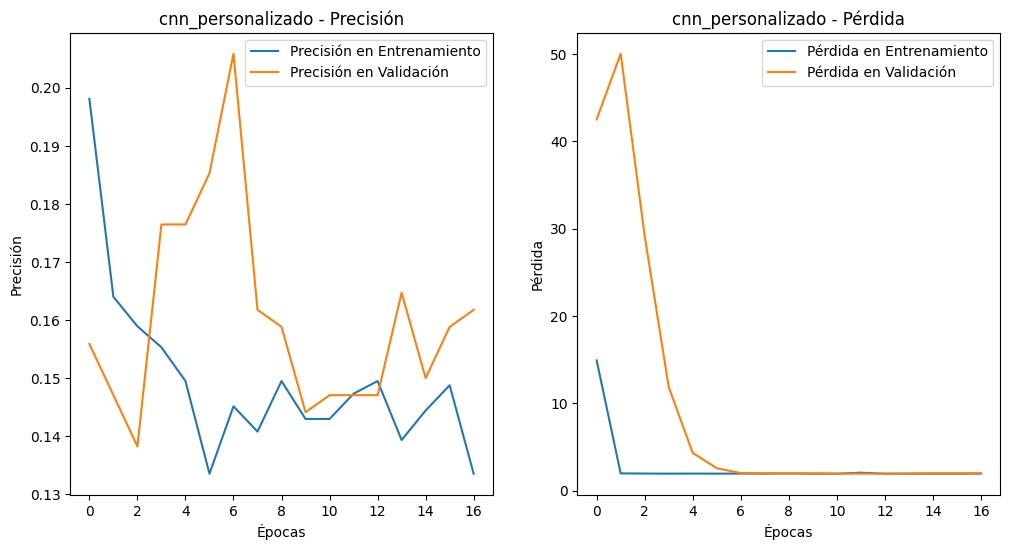


===== Evaluando modelo: cnn_personalizado =====

Classification Report:
                                   precision    recall  f1-score   support

            Bacterial Red disease       0.35      0.12      0.18        48
Bacterial diseases - Aeromoniasis       0.17      0.80      0.29        49
           Bacterial gill disease       0.40      0.12      0.19        48
   Fungal diseases Saprolegniasis       0.33      0.10      0.16        49
                     Healthy Fish       0.28      0.10      0.15        49
               Parasitic diseases       0.16      0.16      0.16        49
Viral diseases White tail disease       0.33      0.02      0.04        48

                         accuracy                           0.21       340
                        macro avg       0.29      0.20      0.17       340
                     weighted avg       0.29      0.21      0.17       340



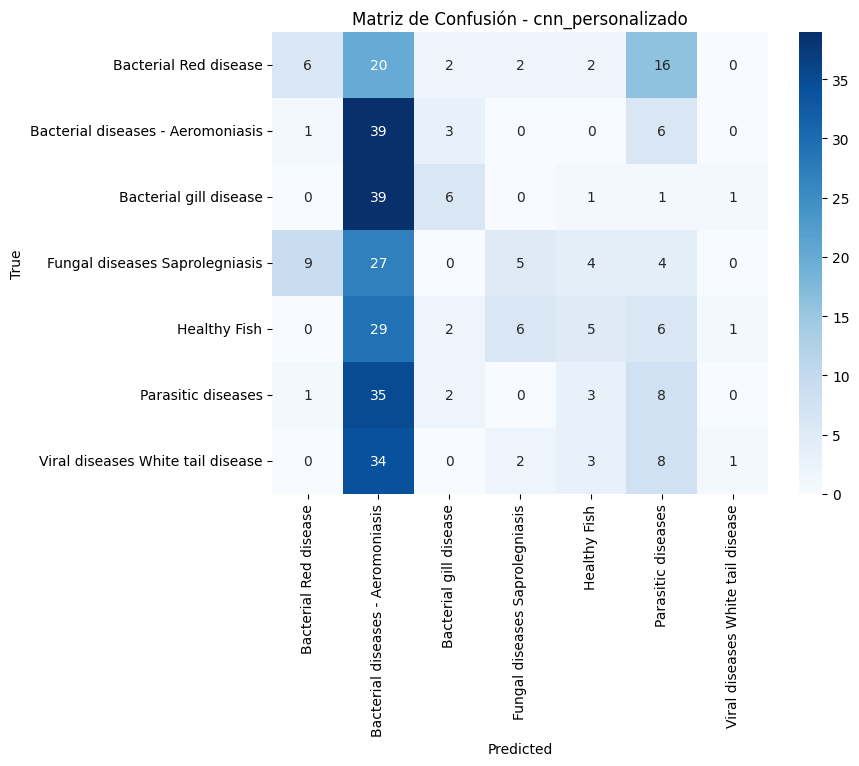

c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



===== Medición de tiempos de inferencia =====

--- Tiempos de inferencia (segundos) ---
50% - max: 2.0903, min: 1.6998, mean: 1.7913, std: 0.1499
100% - max: 3.6354, min: 3.2471, mean: 3.3816, std: 0.1329

===== Evaluación manual de 50 imágenes =====


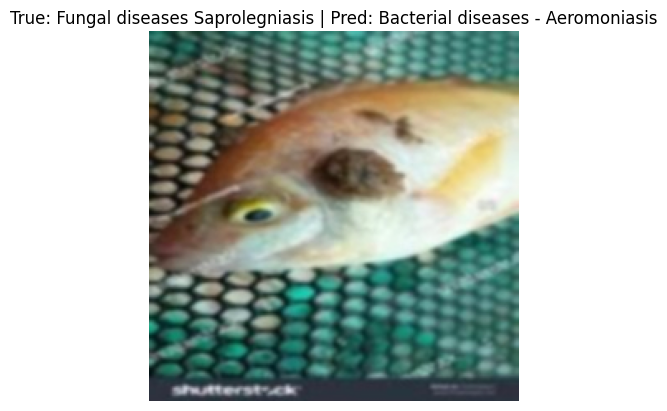

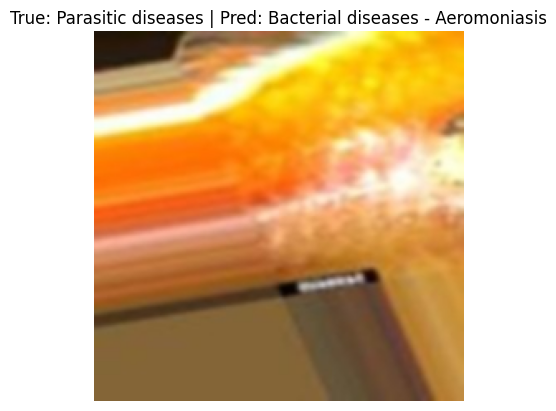

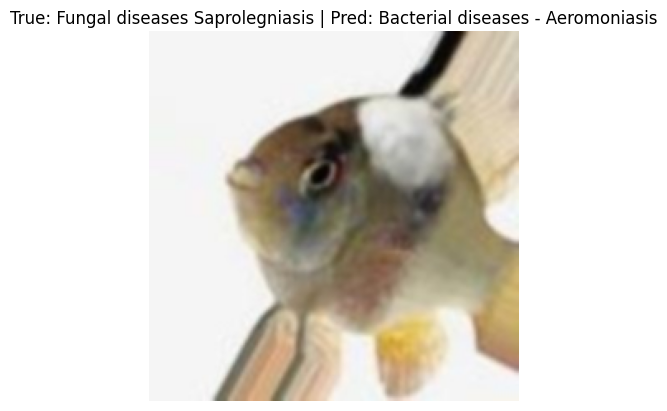

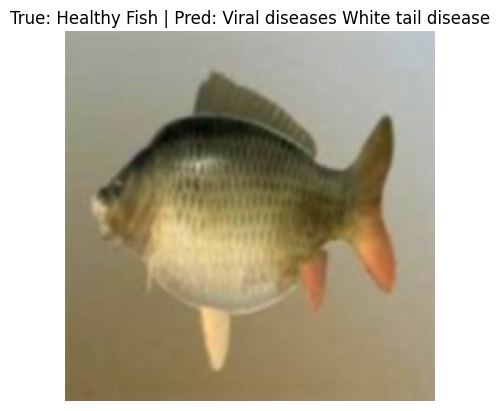

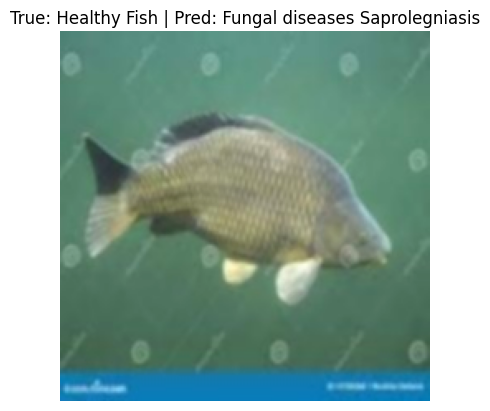

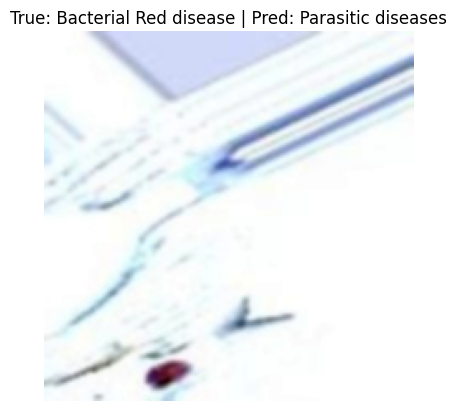

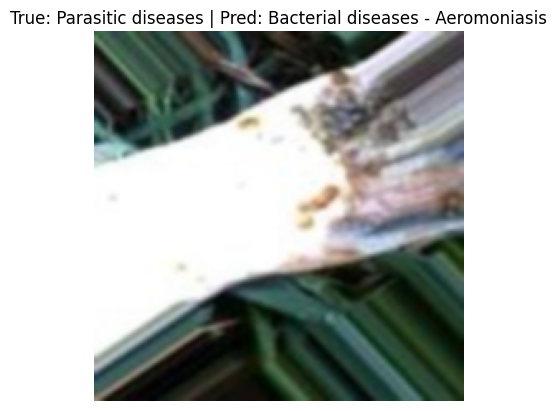

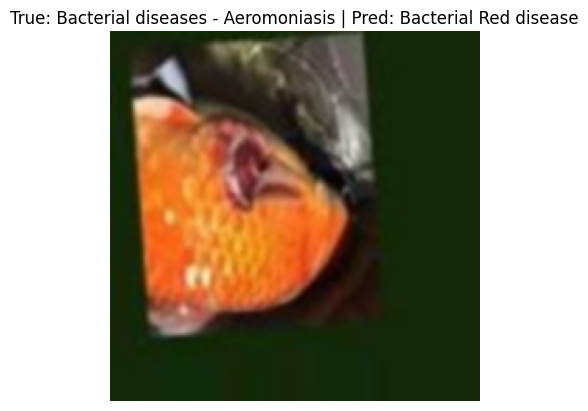

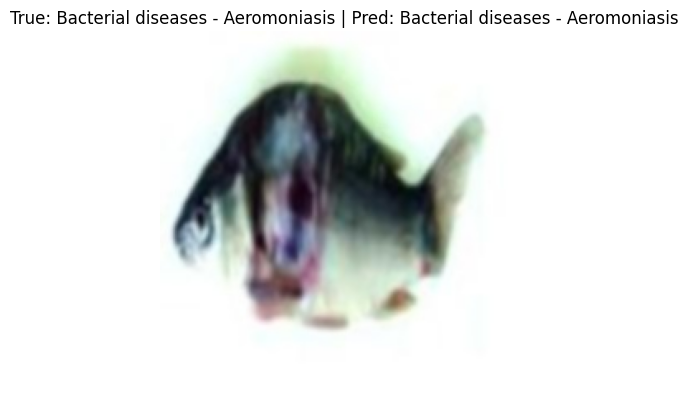

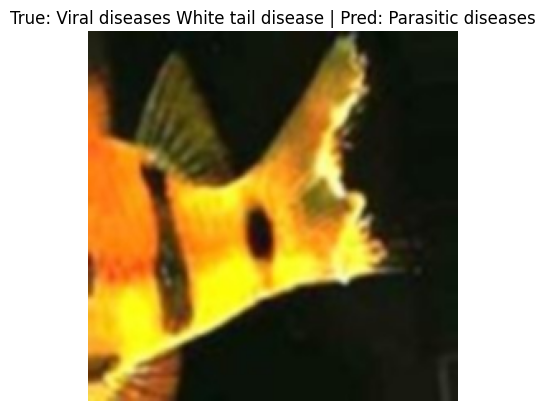


===== Resultados de la Evaluación - cnn_personalizado =====
Precisión en conjunto de prueba: 0.2123
Estadísticas de tiempo para 50% de inferencia: {'max': np.float64(2.090257406234741), 'min': np.float64(1.6997871398925781), 'mean': np.float64(1.7913455963134766), 'std': np.float64(0.14985026801453666)}


In [32]:
# Entrenamiento y Evaluación para cnn_personalizado
model_cnn, history_cnn = entrenamiento(cnn_perzonalizado, 'cnn_personalizado', epochs=epochs)
evaluation_cnn = evaluacion(model_cnn, 'cnn_personalizado', val_gen, test_gen, eval_runs=5, subset_manual=50)

# Mostrar resultados de la evaluación de cnn_personalizado
print("\n===== Resultados de la Evaluación - cnn_personalizado =====")
print(f"Precisión en conjunto de prueba: {evaluation_cnn['test_accuracy']:.4f}")
print("Estadísticas de tiempo para 50% de inferencia:", evaluation_cnn['time_stats_50'])

#### Aplicacion ResNet50


===== Entrenando modelo: ResNet50 =====


c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1309 - loss: 2.0716 - recall_4: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.22619, saving model to ResNet50_best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.1310 - loss: 2.0706 - recall_4: 0.0000e+00 - val_accuracy: 0.2262 - val_loss: 1.9587 - val_recall_4: 0.0000e+00
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1637 - loss: 1.9404 - recall_4: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.22619
49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.1637 - loss: 1.9404 - recall_4: 0.0000e+00 - val_accuracy: 0.1548 - val_loss: 1.9355 - val_recall_4: 0.0000e+00
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1686 - loss: 1.9619 - recall_4: 0.0000e+00
Epoch 3: val_accuracy improved from 0.22619 to 0.25000, saving model to ResNet50_best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.1688 - loss: 1.9620 - recall_4: 0.0000e+00 - val_acc

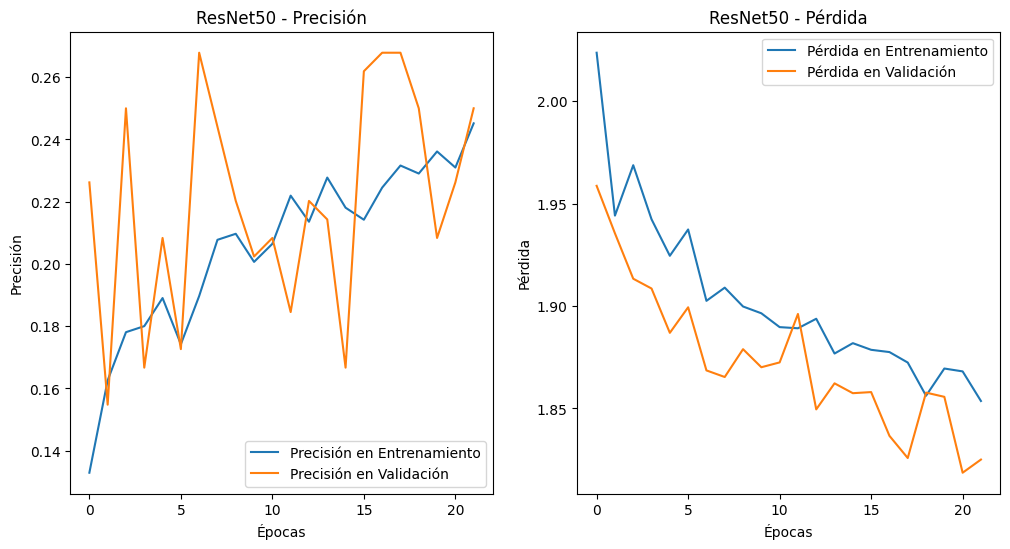


===== Evaluando modelo: ResNet50 =====

Classification Report:
                                   precision    recall  f1-score   support

            Bacterial Red disease       0.50      0.12      0.20        24
Bacterial diseases - Aeromoniasis       0.00      0.00      0.00        24
           Bacterial gill disease       0.29      0.46      0.35        24
   Fungal diseases Saprolegniasis       0.27      0.79      0.40        24
                     Healthy Fish       1.00      0.17      0.29        24
               Parasitic diseases       0.16      0.33      0.22        24
Viral diseases White tail disease       0.00      0.00      0.00        24

                         accuracy                           0.27       168
                        macro avg       0.32      0.27      0.21       168
                     weighted avg       0.32      0.27      0.21       168



c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

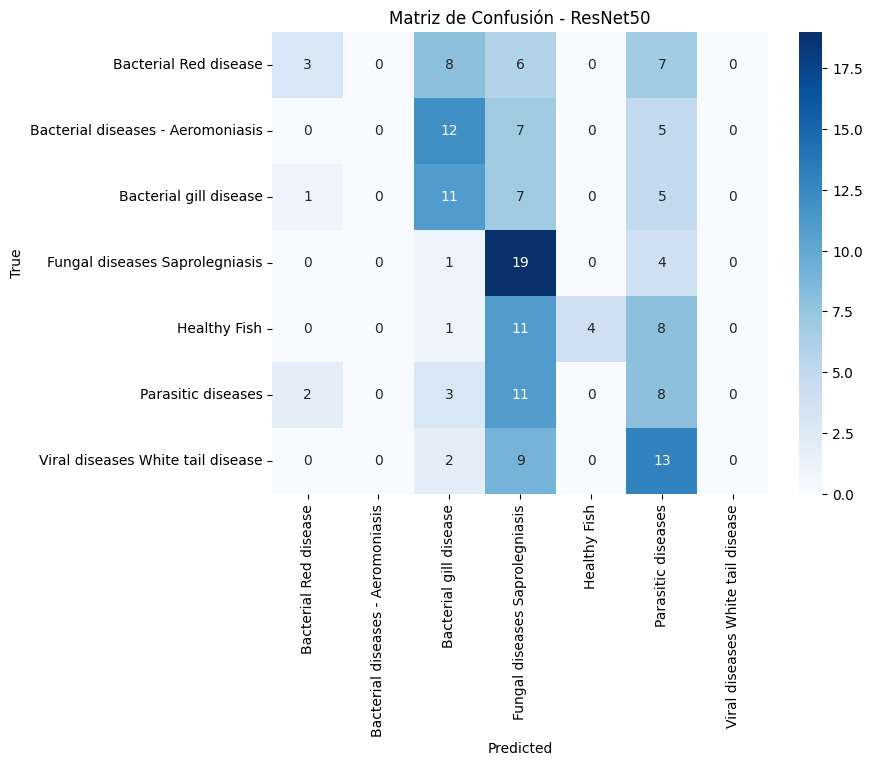

c:\Users\csolis\AppData\Local\anaconda3\envs\webscraping\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



===== Medición de tiempos de inferencia =====

--- Tiempos de inferencia (segundos) ---
50% - max: 8.2228, min: 4.8120, mean: 5.5254, std: 1.3492
100% - max: 10.3581, min: 9.5575, mean: 9.8727, std: 0.3129

===== Evaluación manual de 50 imágenes =====


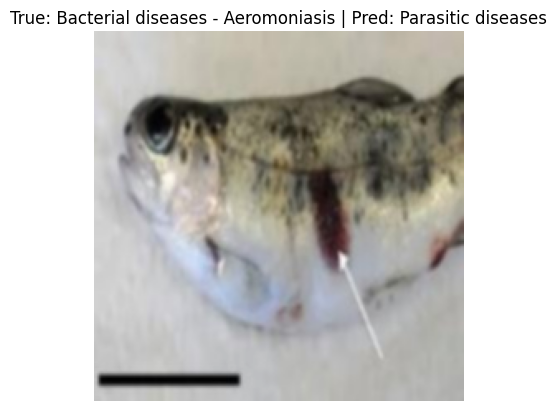

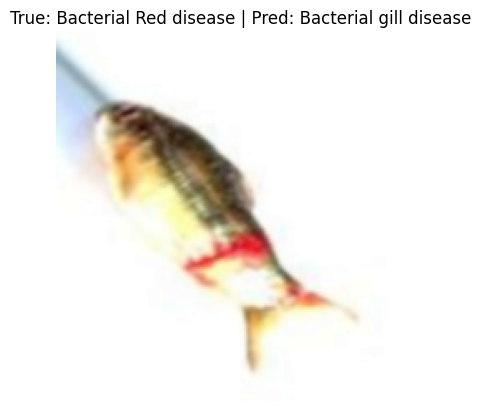

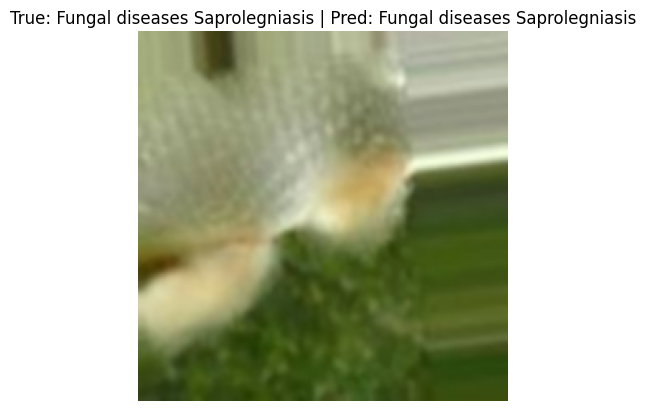

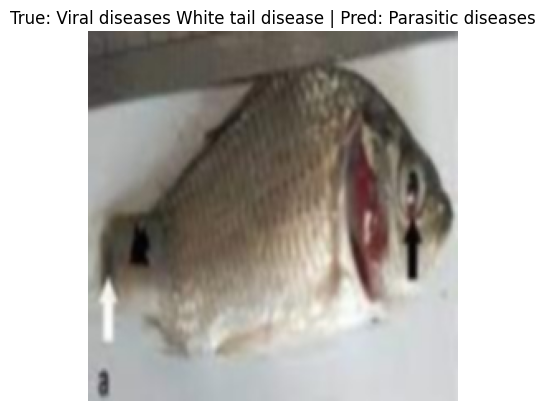

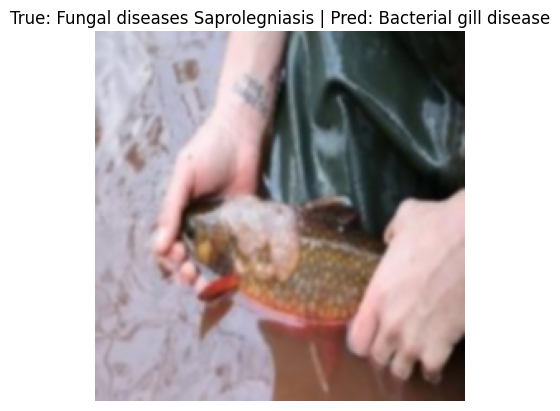

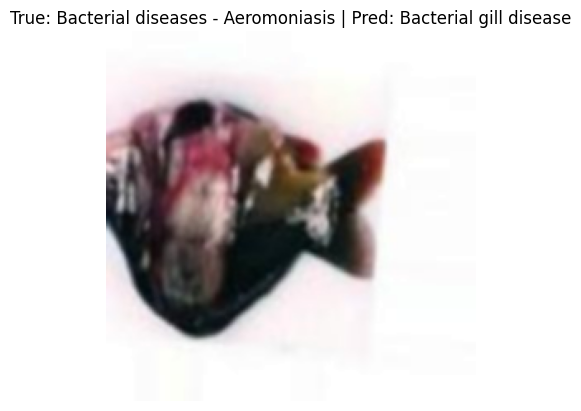

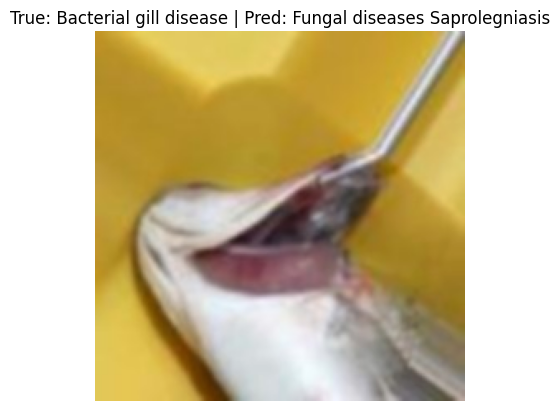

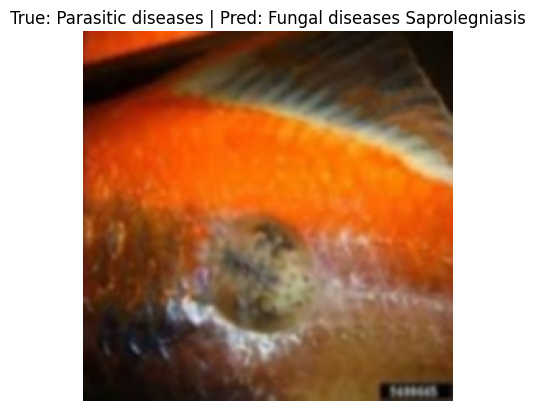

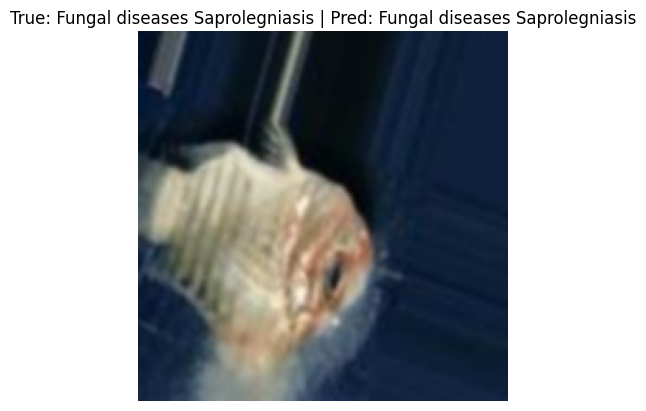

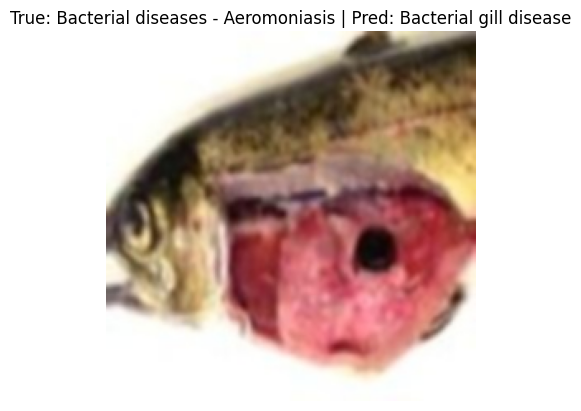


===== Resultados de la Evaluación - ResNet50 =====
Precisión en conjunto de prueba: 0.2826
Pérdida en conjunto de prueba: 1.8483
Estadísticas de tiempo para 50% de inferencia: {'max': np.float64(8.222829103469849), 'min': np.float64(4.812033414840698), 'mean': np.float64(5.525426149368286), 'std': np.float64(1.3492376140010696)}
Estadísticas de tiempo para 100% de inferencia: {'max': np.float64(10.358074426651001), 'min': np.float64(9.557536363601685), 'mean': np.float64(9.872745275497437), 'std': np.float64(0.3128549111296748)}


In [42]:
# Entrenamiento y Evaluación para ResNet50

# Entrenamiento para ResNet50
model_resnet, history_resnet = entrenamiento(resnet50, 'ResNet50', epochs=epochs)

# Evaluación 
evaluation_resnet = evaluacion('ResNet50', val_gen, test_gen, eval_runs=5, subset_manual=50)

# Mostrar resultados de la evaluación de ResNet50
print("\n===== Resultados de la Evaluación - ResNet50 =====")
print(f"Precisión en conjunto de prueba: {evaluation_resnet['test_accuracy']:.4f}")
print(f"Pérdida en conjunto de prueba: {evaluation_resnet['test_loss']:.4f}")
print("Estadísticas de tiempo para 50% de inferencia:", evaluation_resnet['time_stats_50'])
print("Estadísticas de tiempo para 100% de inferencia:", evaluation_resnet['time_stats_100'])